In [ ]:
!wget https://image-net.org/data/ILSVRC/2010/ILSVRC2010_images_val.tar

--2023-08-21 19:37:18--  https://image-net.org/data/ILSVRC/2010/ILSVRC2010_images_val.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5397002240 (5.0G) [application/x-tar]
Saving to: ‘ILSVRC2010_images_val.tar’

ILSVRC2010_images_v 100%[===================>]   5.03G  15.7MB/s    in 5m 52s  

2023-08-21 19:43:11 (14.6 MB/s) - ‘ILSVRC2010_images_val.tar’ saved [5397002240/5397002240]



In [ ]:
!tar xf ILSVRC2010_images_val.tar

In [ ]:
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
dataset_folder_name = 'dataset'

colors = []
color_path = []

if os.path.exists(dataset_folder_name):
  shutil.rmtree(dataset_folder_name)


for i in range(100):
  r = random.randint(0,255)
  g = random.randint(0,255)
  b = random.randint(0,255)
  colors.append((r,g,b))
  fold_name = str(i)
  fold_path = os.path.join(dataset_folder_name, fold_name)
  if os.path.exists(fold_path):
    continue
  os.makedirs(fold_path)
  color_path.append(fold_path)


h = w = 180
folder_name = 'val'

for file_name in os.listdir(folder_name)[:20000]:
  img = cv2.imread(os.path.join(folder_name, file_name))
  img = cv2.resize(img, (h,w))
  col = random.randint(0,99)
  img[:]= colors[col]
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2.imwrite(f'{os.path.join(color_path[col], file_name)}', rgb_img)



In [ ]:
image_size = (h, w)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_folder_name,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
class_num = len(train_ds.class_names)
print(class_num)

Found 20000 files belonging to 100 classes.
Using 16000 files for training.
Using 4000 files for validation.
100


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

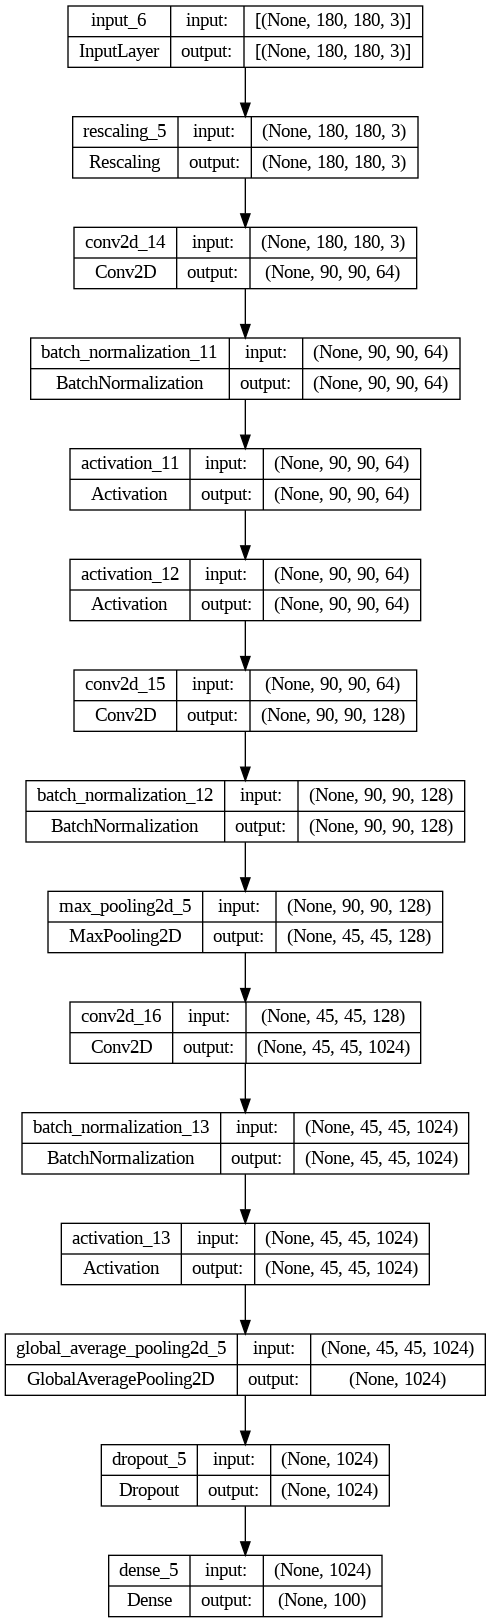

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.000 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # x = layers.Activation("relu")(x)
        # x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        # residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        #     previous_block_activation
        # )
        # x = layers.add([x, residual])  # Add back residual
        # previous_block_activation = x  # Set aside next residual

    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=class_num)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=3, verbose=1)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/10
250/250 [==============================] - 73s 279ms/step - loss: 1.1632 - accuracy: 0.6225 - val_loss: 6.9267 - val_accuracy: 0.0217
Epoch 2/10
250/250 [==============================] - 69s 275ms/step - loss: 0.6022 - accuracy: 0.7770 - val_loss: 0.5064 - val_accuracy: 0.7760
Epoch 3/10
250/250 [==============================] - 69s 275ms/step - loss: 0.5362 - accuracy: 0.8003 - val_loss: 0.2978 - val_accuracy: 0.8785
Epoch 4/10
250/250 [==============================] - 69s 274ms/step - loss: 0.4403 - accuracy: 0.8321 - val_loss: 0.1869 - val_accuracy: 0.9355
Epoch 5/10
250/250 [==============================] - 69s 275ms/step - loss: 0.4084 - accuracy: 0.8429 - val_loss: 0.2091 - val_accuracy: 0.9093
Epoch 6/10
250/250 [==============================] - 69s 274ms/step - loss: 0.3884 - accuracy: 0.8515 - val_loss: 0.1443 - val_accuracy: 0.9465
Epoch 7/10
250/250 [==============================] - 69s 275ms/step - loss: 0.4130 - accuracy: 0.8461 - val_loss: 0.1334 - val_ac

# Adding Noise

In [ ]:
dataset_folder_name = 'dataset'

colors = []
color_path = []

if os.path.exists(dataset_folder_name):
  shutil.rmtree(dataset_folder_name)


for i in range(100):
  r = random.randint(0,255)
  g = random.randint(0,255)
  b = random.randint(0,255)
  colors.append((r,g,b))
  fold_name = str(i)
  fold_path = os.path.join(dataset_folder_name, fold_name)
  if os.path.exists(fold_path):
    continue
  os.makedirs(fold_path)
  color_path.append(fold_path)


h = w = 180
folder_name = 'val'

for file_name in os.listdir(folder_name)[:20000]:
  img = cv2.imread(os.path.join(folder_name, file_name))

  img = cv2.resize(img, (h,w))


  col = random.randint(0,99)
  img[:]= colors[col]

  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mean = 0
  stddev = 180
  noise = np.zeros(img.shape, np.uint8)
  cv2.randn(noise, mean, stddev)
  noisy_img = cv2.add(rgb_img, noise)

  cv2.imwrite(f'{os.path.join(color_path[col], file_name)}', noisy_img)

In [ ]:
image_size = (h, w)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_folder_name,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
class_num = len(train_ds.class_names)
print(class_num)

Found 20000 files belonging to 100 classes.
Using 16000 files for training.
Using 4000 files for validation.
100


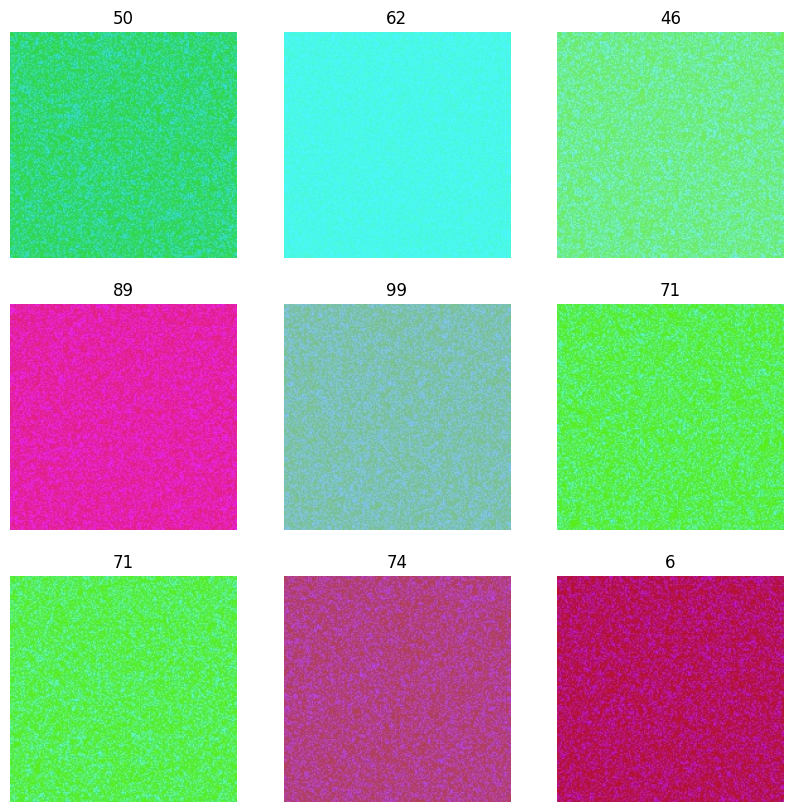

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

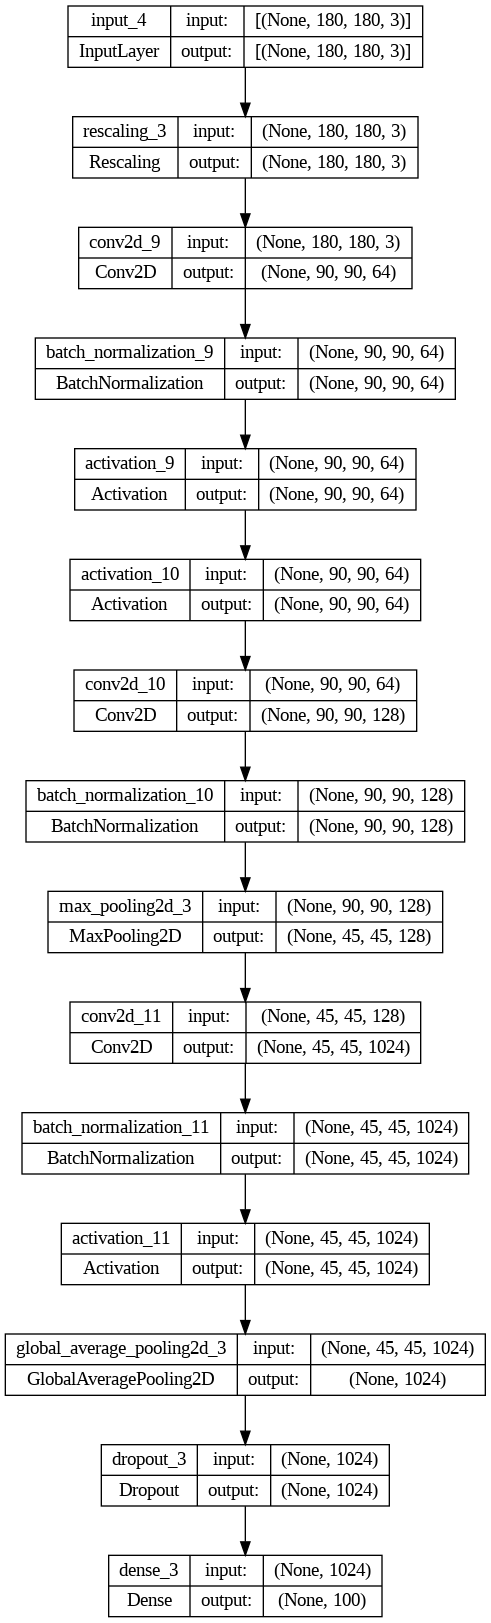

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.000 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # x = layers.Activation("relu")(x)
        # x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        # residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        #     previous_block_activation
        # )
        # x = layers.add([x, residual])  # Add back residual
        # previous_block_activation = x  # Set aside next residual

    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=class_num)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=3, verbose=1)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/10
250/250 [==============================] - 74s 284ms/step - loss: 1.1401 - accuracy: 0.6329 - val_loss: 7.7406 - val_accuracy: 0.0480
Epoch 2/10
250/250 [==============================] - 73s 291ms/step - loss: 0.5260 - accuracy: 0.8079 - val_loss: 0.6136 - val_accuracy: 0.7660
Epoch 3/10
250/250 [==============================] - 73s 289ms/step - loss: 0.4273 - accuracy: 0.8388 - val_loss: 1.1621 - val_accuracy: 0.5835
Epoch 4/10
250/250 [==============================] - 73s 292ms/step - loss: 0.3568 - accuracy: 0.8661 - val_loss: 0.5311 - val_accuracy: 0.8117
Epoch 5/10
250/250 [==============================] - 73s 290ms/step - loss: 0.2918 - accuracy: 0.8910 - val_loss: 0.2408 - val_accuracy: 0.9165
Epoch 6/10
250/250 [==============================] - 73s 290ms/step - loss: 0.2977 - accuracy: 0.8861 - val_loss: 0.0948 - val_accuracy: 0.9505
Epoch 7/10
250/250 [==============================] - 73s 289ms/step - loss: 0.2706 - accuracy: 0.8957 - val_loss: 0.0954 - val_ac